# 1. Análisis Exploratorio de Datos (EDA) - Bank Churn

**Objetivo:** Realizar un análisis descriptivo profundo para identificar patrones de abandono, calidad del dato y correlaciones, tal como se requiere en la fase de "Comprensión y preprocesado de datos".

**Entradas:** `data/raw/train.csv`
**Salidas:** Gráficos para la memoria y estrategia definida para el pipeline de limpieza.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from pathlib import Path
import sys

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

from src.config import RAW_TRAIN_PATH
   
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
warnings.filterwarnings('ignore')

output_dir = "../docs/images"
os.makedirs(output_dir, exist_ok=True)

try:
    df = pd.read_csv(RAW_TRAIN_PATH)
    print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
except FileNotFoundError:
    print(f"Error: No se encuentra el archivo. Verifica la ruta {RAW_TRAIN_PATH}")

df_eda = df.drop(columns=['CustomerId', 'Surname'], errors='ignore')

[2025-11-29 10:40:16][src.config][INFO] Loading parameters from /home/miguel/Documents/UIMP/aprendizaje_automatico/ml-finance-churn-model/config/params.yaml
[2025-11-29 10:40:16][src.config][INFO] Dynamic features loaded from selected_features.json
[2025-11-29 10:40:16][src.config][INFO] Dynamic features: comments='Variables seleccionadas automaticamente por Boruta' date='2025-11-19 23:04' features=FeaturesDetail(numeric=['Age', 'Balance', 'IsActiveMember', 'BalanceSalaryRatio', 'TenureAgeRatio', 'CreditScore', 'EstimatedSalary'], categorical=['Geography', 'Gender', 'NumOfProducts'])
[2025-11-29 10:40:16][src.config][INFO] 🚀 Using DYNAMIC feature configuration (Boruta).


Dataset cargado con éxito. Dimensiones: (8000, 13)


## 1. Análisis de datos EDA utilizando herramientas de Profiling (ydata-profiling)

In [2]:
from ydata_profiling import ProfileReport
profile = ProfileReport(
    df, 
    title="Bank Churn - Profiling Report",
    explorative=True,
)

output_html_path = os.path.join("../docs/profiling_output", "profile_report.html")
profile.to_file(output_html_path)

output_json_path = os.path.join("../docs/profiling_output", "profile_report.json")
profile.to_file(output_json_path)

print(f"Reporte de profiling generado y guardado en: {output_html_path}")

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 19.35it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte de profiling generado y guardado en: ../docs/profiling_output/profile_report.html


## 2. Análisis de Calidad del Dato
Según el perfilado inicial, existen variables con una alta tasa de ceros y nulos. Es crítico distinguir si un `0` es un valor real (ej. saldo agotado) o un dato faltante, especialmente en la variable `Balance`.

<Figure size 1200x600 with 0 Axes>

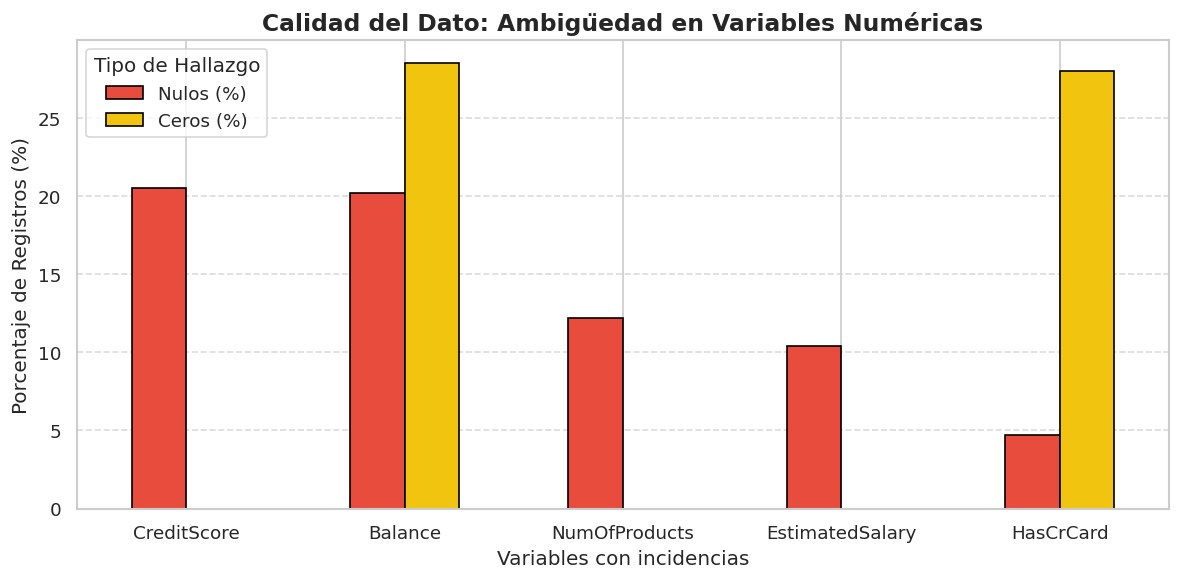


--- INSIGHTS PARA LA MEMORIA ---
1. CASO BALANCE: Tenemos un 20.2% de datos perdidos (Nulos) vs un 28.5% de saldo agotado (Ceros).
   -> Conclusión: Son fenómenos distintos. Imputaremos nulos, mantendremos ceros.


In [2]:
valid_zero_cols = ['Exited', 'IsActiveMember', 'Tenure']

percent_nulls = df_eda.isnull().mean() * 100

percent_zeros = (df_eda == 0).mean() * 100
percent_zeros[valid_zero_cols] = 0

quality_metrics = pd.DataFrame({
    'Nulos (%)': percent_nulls,
    'Ceros (%)': percent_zeros
})

quality_metrics = quality_metrics[(quality_metrics['Nulos (%)'] > 0) | (quality_metrics['Ceros (%)'] > 0)]
quality_metrics = quality_metrics.sort_values('Nulos (%)', ascending=False)

plt.figure(figsize=(10, 5))
quality_metrics.plot(kind='bar', stacked=False, color=['#e74c3c', '#f1c40f'], edgecolor='black', figsize=(10, 5))

plt.title('Calidad del Dato: Ambigüedad en Variables Numéricas', fontsize=14, fontweight='bold')
plt.ylabel('Porcentaje de Registros (%)')
plt.xlabel('Variables con incidencias')
plt.xticks(rotation=0) # Rotación 0 para leer bien nombres cortos
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Hallazgo')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_quality_check_clean.png'))
plt.show()

print("\n--- INSIGHTS PARA LA MEMORIA ---")
if 'Balance' in quality_metrics.index:
    nulos = quality_metrics.loc['Balance', 'Nulos (%)']
    ceros = quality_metrics.loc['Balance', 'Ceros (%)']
    print(f"1. CASO BALANCE: Tenemos un {nulos:.1f}% de datos perdidos (Nulos) vs un {ceros:.1f}% de saldo agotado (Ceros).")
    print("   -> Conclusión: Son fenómenos distintos. Imputaremos nulos, mantendremos ceros.")

## 2. Análisis de la Variable Objetivo (`Exited`)
Evaluamos el desbalanceo de clases para determinar la métrica de evaluación adecuada (F1-Score vs Accuracy).

In [3]:
plt.figure(figsize=(6, 4))

exited_counts = df_eda['Exited'].value_counts()
colors = ['#3498db', '#e74c3c']

plt.pie(exited_counts, labels=['Retenido (0)', 'Abandono (1)'], autopct='%1.1f%%', 
        startangle=90, colors=colors, wedgeprops={'width': 0.4, 'edgecolor': 'white'})

plt.title('Distribución de Clientes (Churn)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_target_distribution.png'))
plt.show()

## 3. Análisis Univariante: Distribuciones y Detección de Outliers

Antes de evaluar cómo influyen las variables en el abandono, analizamos su comportamiento individual para detectar:
1.  **Distribuciones:** ¿Son gaussianas (normales) o están sesgadas? Esto influye en la necesidad de escalado (StandardScaler vs MinMaxScaler).
2.  **Outliers:** Valores extremos que pueden distorsionar modelos sensibles a la distancia (como KNN o SVM) o estadísticas básicas.

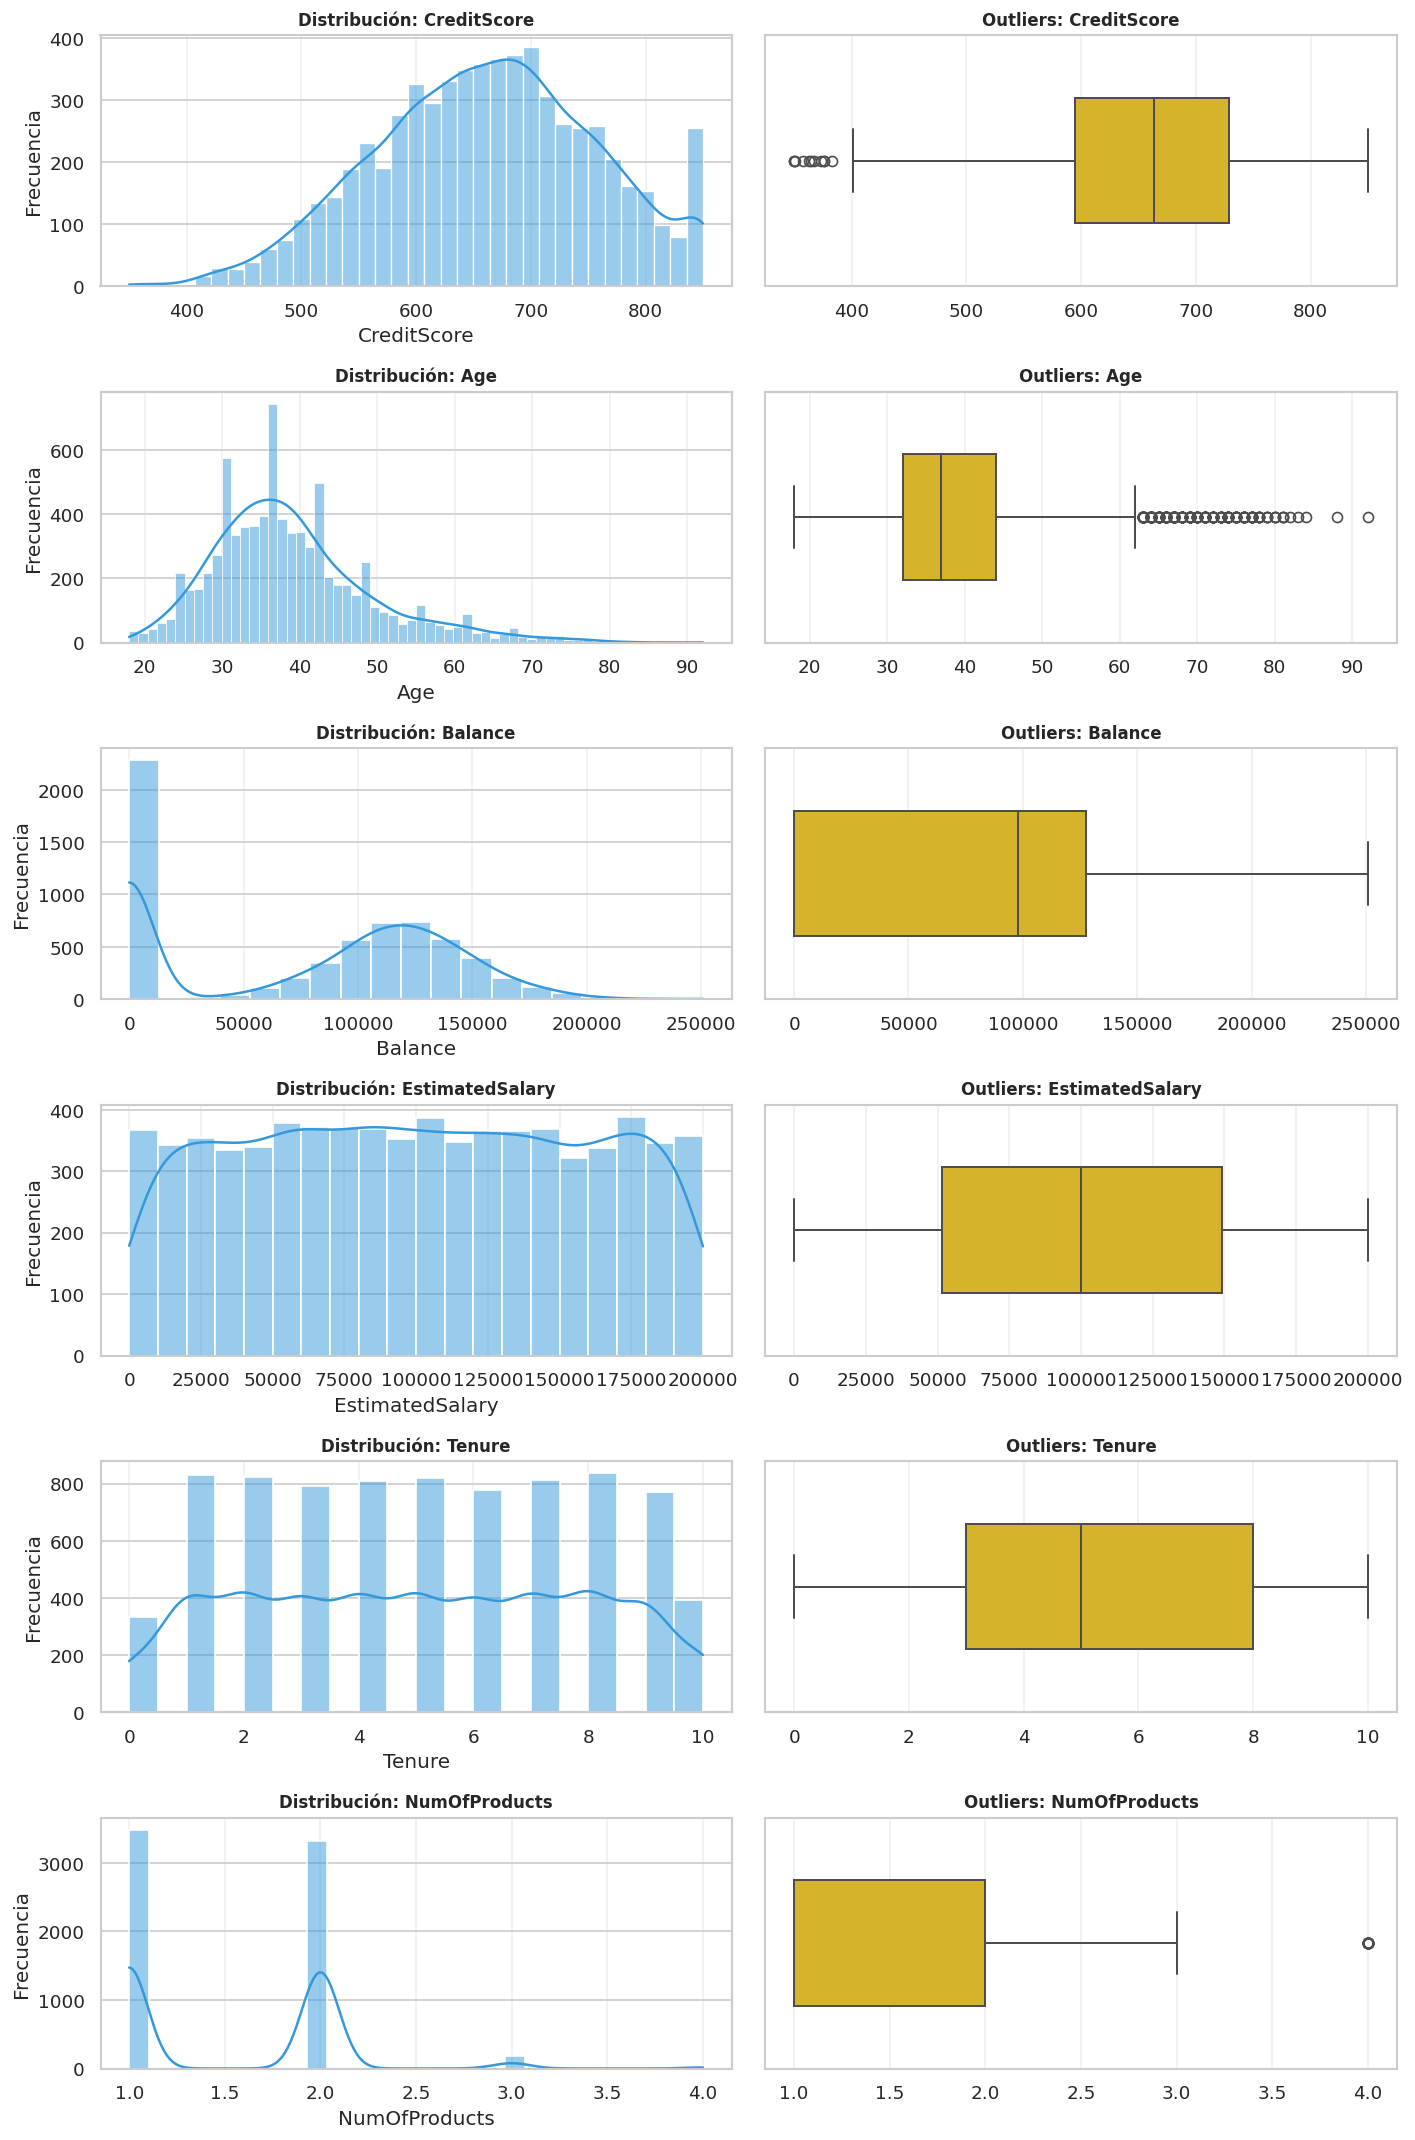

--- Asimetría (Skewness) ---
Valor > 1 o < -1 indica distribución muy sesgada.
Age                1.006054
NumOfProducts      0.641585
Tenure             0.006486
EstimatedSalary    0.002925
CreditScore       -0.120384
Balance           -0.152789
dtype: float64


In [4]:
vars_continuas = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']

fig, axes = plt.subplots(len(vars_continuas), 2, figsize=(12, 18))

for i, col in enumerate(vars_continuas):
    sns.histplot(data=df_eda, x=col, kde=True, ax=axes[i, 0], color='#3498db', edgecolor='white')
    axes[i, 0].set_title(f'Distribución: {col}', fontsize=10, fontweight='bold')
    axes[i, 0].set_ylabel('Frecuencia')
    axes[i, 0].grid(axis='x', alpha=0.3)
    
    sns.boxplot(data=df_eda, x=col, ax=axes[i, 1], color='#f1c40f', width=0.5, linewidth=1.2)
    axes[i, 1].set_title(f'Outliers: {col}', fontsize=10, fontweight='bold')
    axes[i, 1].set_xlabel('')
    axes[i, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_univariate_dist_outliers.png'))
plt.show()

print("--- Asimetría (Skewness) ---")
print("Valor > 1 o < -1 indica distribución muy sesgada.")
print(df_eda[vars_continuas].skew().sort_values(ascending=False))

**Hallazgos Univariantes:**
* **Edad (`Age`):** Muestra una clara asimetría positiva (cola a la derecha) y **numerosos outliers** en el rango superior (>60 años). No son errores, sino clientes mayores, por lo que se recomienda usar modelos robustos o transformaciones no lineales.
* **Score Crediticio (`CreditScore`):** Distribución cuasi-normal, centrada en ~650 puntos, con algunos outliers en la parte baja (<400 puntos).
* **Balance (`Balance`):** Distribución bimodal clara debido al gran número de clientes con saldo 0 (como se vio en el análisis de calidad), seguido de una distribución normal para los que sí tienen saldo.

## 4. Factores Determinantes del Abandono
Analizamos las relaciones bivariadas más fuertes detectadas: **Edad** (Age) y **Geografía** (Geography).

In [5]:
df_plot = df_eda.copy()
df_plot['Status'] = df_plot['Exited'].map({0: 'Retenido', 1: 'Abandono'})
palette_status = {"Retenido": "#3498db", "Abandono": "#e74c3c"}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Graph A: Age boxplot---
sns.boxplot(data=df_plot, x='Status', y='Age', palette=palette_status, ax=axes[0], width=0.5, linewidth=1.2)
axes[0].set_title('Impacto de la Edad en el Abandono', fontsize=12, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Edad (Años)')

# --- Graph B: Churn rate per country ---
country_churn = df_plot.groupby('Geography')['Exited'].value_counts(normalize=True).mul(100).rename('Porcentaje').reset_index()
country_churn = country_churn[country_churn['Exited'] == 1]

sns.barplot(data=country_churn, x='Geography', y='Porcentaje', color='#e74c3c', ax=axes[1], edgecolor='black')

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[1].set_title('Tasa de Abandono por País', fontsize=12, fontweight='bold')
axes[1].set_ylabel('% de Clientes que Abandonan')
axes[1].set_ylim(0, 50)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_key_factors.png'))
plt.show()

## 5. Análisis Multivariable y Correlaciones
Generamos una matriz de correlación completa para detectar:
1. Variables que más influyen en `Exited`.
2. Posible multicolinealidad entre variables predictoras.

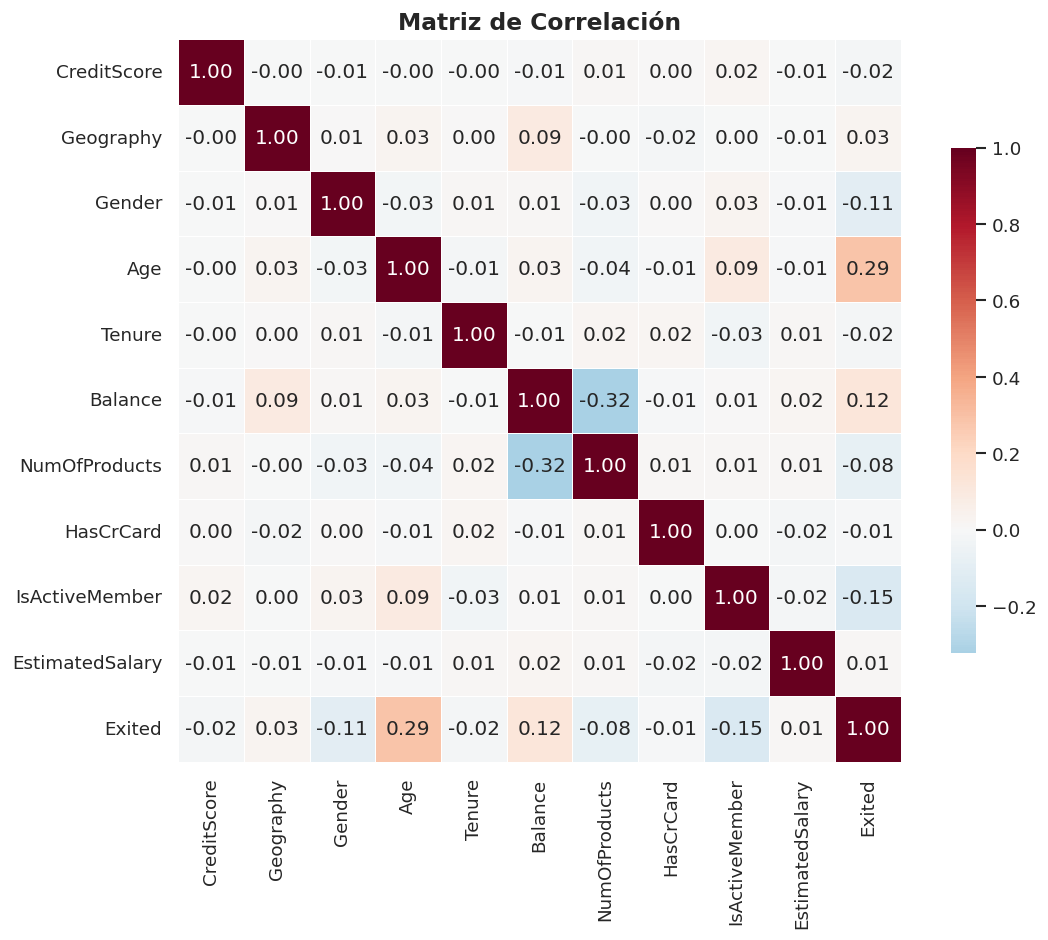

In [6]:
plt.figure(figsize=(10, 8))

df_corr = df_eda.copy()
for col in df_corr.select_dtypes(include=['object', 'category']).columns:
    df_corr[col] = df_corr[col].astype('category').cat.codes

sorted_cols = [c for c in df_corr.columns if c != 'Exited'] + ['Exited']
df_corr = df_corr[sorted_cols]

corr_matrix = df_corr.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7})

plt.title('Matriz de Correlación', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_correlation_matrix.png'))
plt.show()

### 5.1 Análisis Detallado de Comportamiento y Demografía

Mediante este análisis se persigue profundizar en el comportamiento del cliente así como en los factores demográficos con el objetivo de identificar patrones y tendencias que puedan ayudar a predecir el comportamiento de los clientes.

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graph 1: NON LINEAL behaviour of NumOfProducts feature
sns.countplot(data=df_eda, x='NumOfProducts', hue='Exited', palette={0: '#3498db', 1: '#e74c3c'}, ax=axes[0])
axes[0].set_title('Churn por Número de Productos', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Cantidad de Clientes')
axes[0].legend(title='Exited', labels=['Retenido', 'Abandono'])

# Graph 2: Gender bias
churn_gender = df_eda.groupby('Gender')['Exited'].value_counts(normalize=True).mul(100).rename('Porcentaje').reset_index()
churn_gender = churn_gender[churn_gender['Exited'] == 1] # Solo tasa de fuga

sns.barplot(data=churn_gender, x='Gender', y='Porcentaje', color='#e74c3c', ax=axes[1], edgecolor='black')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontweight='bold')
axes[1].set_title('Tasa de Abandono por Género', fontsize=11, fontweight='bold')
axes[1].set_ylim(0, 50)

# Graph 3: Age vs Balance
sns.scatterplot(data=df_eda, x='Age', y='Balance', hue='Exited', palette={0: '#3498db', 1: '#e74c3c'}, alpha=0.6, ax=axes[2])
axes[2].set_title('Interacción: Edad vs. Balance', fontsize=11, fontweight='bold')
axes[2].legend(title='Exited', loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_behavior_demographics.png'))
plt.show()

print("--- Tasa de Abandono por Nº Productos ---")
print(df_eda.groupby('NumOfProducts')['Exited'].mean() * 100)

--- Tasa de Abandono por Nº Productos ---
NumOfProducts
1.0     28.645235
2.0      7.071923
3.0     80.327869
4.0    100.000000
Name: Exited, dtype: float64


Como se puede observar en los diagramas previos se detectaron los siguientes patrones:

1. Se ha identificado una **relación no lineal** y significativa entre el **número de productos contratados y la tasa de abandono**. Específicamente, la tasa de abandono alcanza su punto mínimo en clientes con dos productos, pero experimenta un incremento abrupto a partir de tres o más productos. Esta no linealidad sugiere que el tratamiento de dicha variable como continua podría impactar negativamente en el rendimiento de modelos lineales. Por consiguiente, se considera una candidata idónea para ser transformada mediante técnicas de discretización o binning, lo que permitiría al modelo capturar este comportamiento de forma más efectiva.
2. Se ha identificado una brecha demográfica de género, presentando las mujeres una tasa de abandono superior a los hombres. Esto implica que es una variable discriminante y por tanto susceptible de ser añadida al modelo.
3. **Interacción Edad vs. Balance** (Gráfico Derecho) El diagrama de dispersión revela cómo interactúan la edad y el saldo en la decisión de abandonar:

    * Dominancia de la Edad: La nube de puntos naranjas (abandono) se concentra claramente en el rango de edad de 40 a 65 años, independientemente del saldo que tengan.

    * Independencia del Saldo: A diferencia de la edad, no se aprecia una frontera clara en el eje Y (Balance). Los clientes abandonan tanto con saldos altos como bajos.

    * Cluster de Riesgo: Se identifica visualmente un "cluster de riesgo" de clientes de mediana edad (40-60 años) con saldos medios-altos que tienden a fugarse, lo que sugiere que la entidad está perdiendo clientes de alto valor en ese rango etario.


## 6. Conclusiones y Estrategia de Preprocesado

Tras el análisis visual y estadístico, se establecen las siguientes acciones para el pipeline:

1.  **Gestión de Nulos e Identificadores:**
    * Eliminación de `CustomerId` y `Surname` (sin valor predictivo).
    * Imputación de `CreditScore`, `Age` y `EstimatedSalary` mediante la **Mediana** (robusta a outliers).
    * **Tratamiento especial para `Balance`:** Se detecta un 28% de ceros que son valores reales. Se imputarán solo los nulos (NaN) y se creará una bandera binaria `missing_balance` si fuera necesario.

2.  **Codificación de Variables:**
    * Uso de **One-Hot Encoding** para `Geography` (crítico por la anomalía de Alemania) y `Gender`.

3.  **Ingeniería de Características (Hipótesis):**
    * Dada la fuerte correlación de `Age` y la inversa de `IsActiveMember`, se sugiere crear interacciones como `Age * IsActiveMember` o ratios `Balance / Age` para mejorar el poder predictivo del modelo.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        X_new['HasBalance'] = (X_new['Balance'] > 0).astype(int)
        X_new['LogBalance'] = np.log1p(X_new['Balance'])
        X_new['BalancePerProduct'] = X_new['Balance'] / X_new['NumOfProducts'].replace(0, 1)
        X_new['BalanceSalaryRatio'] = X_new['Balance'] / X_new['EstimatedSalary'].replace(0, 1)

        X_new['Age_Active_Interaction'] = X_new['Age'] * X_new['IsActiveMember']
        X_new['TenureAgeRatio'] = X_new['Tenure'] / X_new['Age'].replace(0, 1)
        X_new['CreditScore_Age_Ratio'] = X_new['CreditScore'] / X_new['Age'].replace(0, 1)

        X_new['Products_Active_Interaction'] = X_new['NumOfProducts'] * X_new['IsActiveMember']
        X_new['HasMultipleProducts'] = (X_new['NumOfProducts'] > 1).astype(int)

        X_new['CreditScore_Salary_Ratio'] = X_new['CreditScore'] / (X_new['EstimatedSalary'] / 1000).replace(0, 1)
        X_new['HighCreditScore'] = (X_new['CreditScore'] > 700).astype(int)

        X_new['CustomerEngagement'] = (
            X_new['IsActiveMember'] + X_new['HasCrCard'] +
            (X_new['NumOfProducts'] > 1).astype(int)
        )

        X_new['RiskScore'] = (
            (X_new['Age'] > 50).astype(int) +
            (X_new['NumOfProducts'] > 2).astype(int) +
            (1 - X_new['IsActiveMember']) +
            (X_new['Balance'] == 0).astype(int)
        )

        return X_new

## 7. Matriz de Correlación con Features Engineered

Aplicamos el `FeatureEngineer` al dataset de test para analizar las correlaciones después de añadir las features derivadas.

In [3]:
# Cargar dataset de test
from src.config import RAW_TRAIN_PATH

try:
    df_train = pd.read_csv(RAW_TRAIN_PATH)
    print(f"Dataset de entrenamiento cargado. Dimensiones: {df_train.shape}")
except FileNotFoundError:
    print(f"Error: No se encuentra el archivo de entrenamiento en {RAW_TRAIN_PATH}")

df_train_new = df_train.copy()

df_train_new['HasBalance'] = (df_train_new['Balance'] > 0).astype(int)
df_train_new['LogBalance'] = np.log1p(df_train_new['Balance'])
df_train_new['BalancePerProduct'] = df_train_new['Balance'] / df_train_new['NumOfProducts'].replace(0, 1)
df_train_new['BalanceSalaryRatio'] = df_train_new['Balance'] / df_train_new['EstimatedSalary'].replace(0, 1)
df_train_new['Age_Active_Interaction'] = df_train_new['Age'] * df_train_new['IsActiveMember']
df_train_new['TenureAgeRatio'] = df_train_new['Tenure'] / df_train_new['Age'].replace(0, 1)
df_train_new['CreditScore_Age_Ratio'] = df_train_new['CreditScore'] / df_train_new['Age'].replace(0, 1)
df_train_new['Products_Active_Interaction'] = df_train_new['NumOfProducts'] * df_train_new['IsActiveMember']
df_train_new['HasMultipleProducts'] = (df_train_new['NumOfProducts'] > 1).astype(int)
df_train_new['CreditScore_Salary_Ratio'] = df_train_new['CreditScore'] / (df_train_new['EstimatedSalary'] / 1000).replace(0, 1)
df_train_new['HighCreditScore'] = (df_train_new['CreditScore'] > 700).astype(int)
df_train_new['CustomerEngagement'] = (
    df_train_new['IsActiveMember'] + df_train_new['HasCrCard'] +
    (df_train_new['NumOfProducts'] > 1).astype(int)
)
df_train_new['RiskScore'] = (
    (df_train_new['Age'] > 50).astype(int) +
    (df_train_new['NumOfProducts'] > 2).astype(int) +
    (1 - df_train_new['IsActiveMember']) +
    (df_train_new['Balance'] == 0).astype(int)
)

print(f"\nDimensiones después de feature engineering: {df_train_new.shape}")
print(f"Nuevas features creadas: {df_train_new.shape[1] - df_train.shape[1]}")
print(f"\nNuevas columnas añadidas:")
new_cols = [col for col in df_train_new.columns if col not in df_train.columns]
for col in new_cols:
    print(f"  - {col}")

Dataset de entrenamiento cargado. Dimensiones: (8000, 13)

Dimensiones después de feature engineering: (8000, 26)
Nuevas features creadas: 13

Nuevas columnas añadidas:
  - HasBalance
  - LogBalance
  - BalancePerProduct
  - BalanceSalaryRatio
  - Age_Active_Interaction
  - TenureAgeRatio
  - CreditScore_Age_Ratio
  - Products_Active_Interaction
  - HasMultipleProducts
  - CreditScore_Salary_Ratio
  - HighCreditScore
  - CustomerEngagement
  - RiskScore


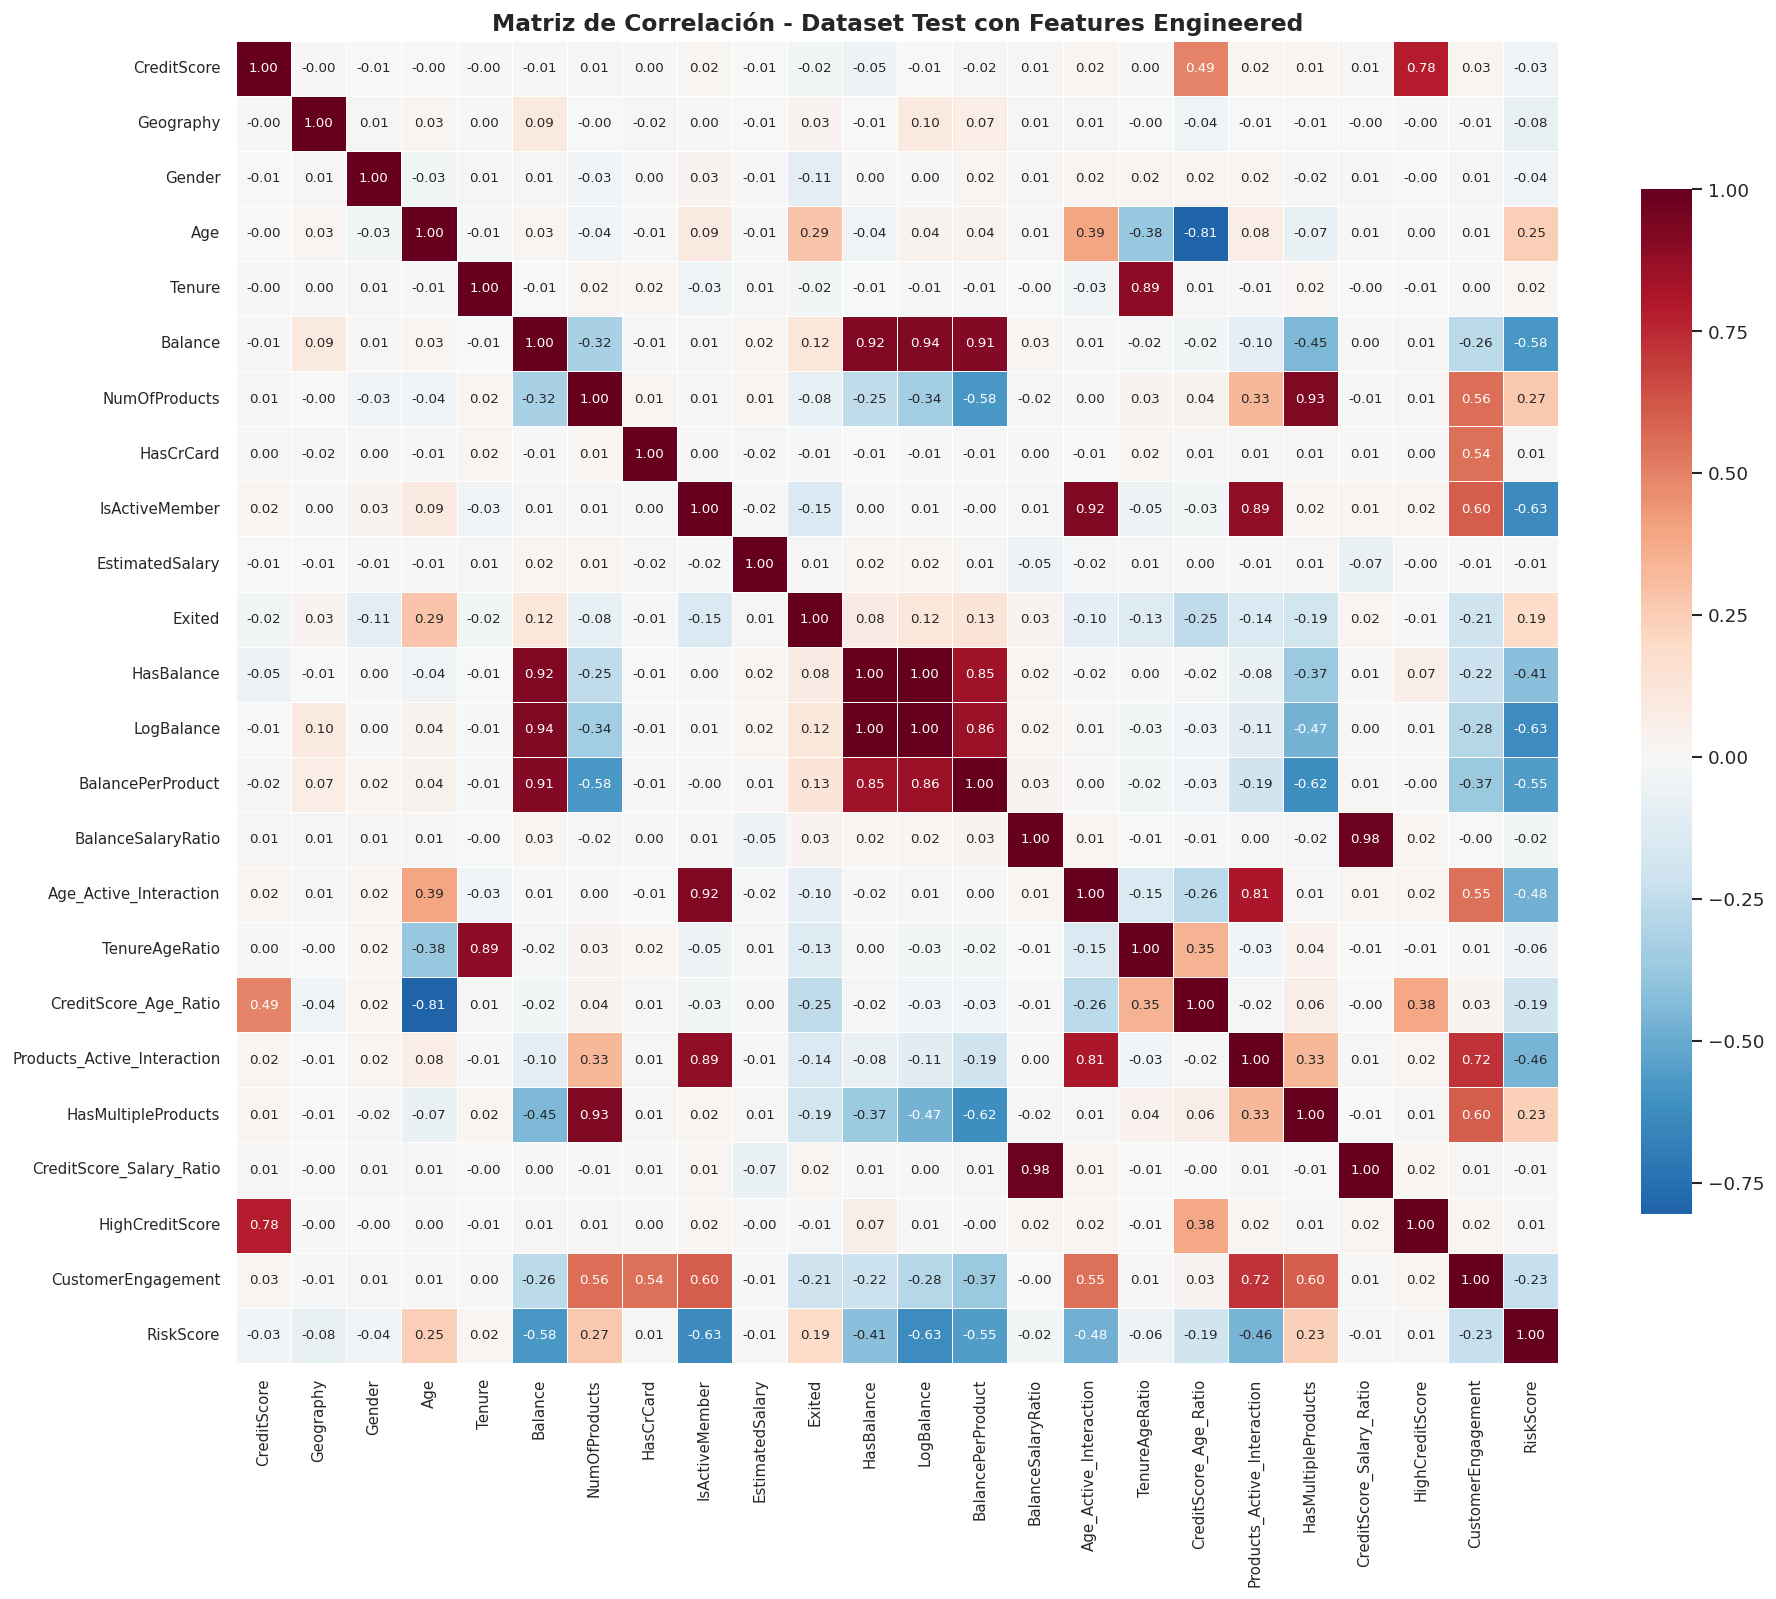

In [4]:
# Preparar datos para la matriz de correlación
df_corr_engineered = df_train_new.drop(columns=['CustomerId', 'Surname'], errors='ignore').copy()

# Codificar variables categóricas
for col in df_corr_engineered.select_dtypes(include=['object', 'category']).columns:
    df_corr_engineered[col] = df_corr_engineered[col].astype('category').cat.codes

# Calcular matriz de correlación
corr_matrix_engineered = df_corr_engineered.corr()

# Visualizar matriz de correlación
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix_engineered, annot=True, fmt=".2f", cmap='RdBu_r', 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7},
            annot_kws={"size": 8})

plt.title('Matriz de Correlación - Dataset Test con Features Engineered', 
          fontsize=14, fontweight='bold')
plt.yticks(rotation=0, fontsize=9)
plt.xticks(rotation=90, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'eda_correlation_matrix_engineered.png'))
plt.show()

#print("\n--- Top 10 Correlaciones más fuertes (valor absoluto) ---")
## Obtener correlaciones sin la diagonal
#corr_pairs = corr_matrix_engineered.abs().unstack()
#corr_pairs = corr_pairs[corr_pairs < 1]  # Excluir diagonal
#corr_pairs = corr_pairs.sort_values(ascending=False).drop_duplicates()
#print(corr_pairs.head(10))

### Análisis Resultado

Tras añadir las variables mencionadas en el análisis previo se observa que el modelo presenta un mejor rendimiento en la detección de clientes propensos a abandonar, con un aumento del f1-score asociado y sin penalizar la maldición de la dimensionalidad ni producir overfitting. El modelo logra un mejor equilibrio entre sensibilidad y especificidad, lo que permite una identificación más precisa de los clientes en riesgo de churn. Se probó a eliminar variables redundantes como por ejemplo "Balance" o "NumProducts" pero el resultado fue inferior

### Selección de Variables Boruta

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from boruta import BorutaPy
import warnings
import os
from pathlib import Path
import sys
import json

X = df_train_new.drop(columns=['Exited'])
y = df_train_new['Exited']

cols_to_drop = ['CustomerId', 'Surname']
X = X.drop(columns=cols_to_drop, errors='ignore')

X.replace([np.inf, -np.inf], 0, inplace=True) 

# 4. Gestión de Nulos (basado en EDA)
#    - Variables numéricas: Imputamos con Mediana
#    - Variables categóricas: Imputamos con Moda (si hubiera, aunque Geography no tenía nulos)
#    - Balance: Aunque tiene ceros reales, los nulos (NaN) deben llenarse.
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

imputer_num = SimpleImputer(strategy='median')
X[num_cols] = imputer_num.fit_transform(X[num_cols])

# 5. Codificación de Categóricas (One-Hot Encoding)
#    Usamos get_dummies para convertir Geography -> Geography_Germany, etc.
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# 6. Conversión final a Numpy (Requisito de BorutaPy)
X_boruta = X.values
y_boruta = y.values

print("Datos preparados para Boruta.")
print(f"Features finales ({X.shape[1]}): {list(X.columns)}")

Datos preparados para Boruta.
Features finales (26): ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'HasBalance', 'LogBalance', 'BalancePerProduct', 'BalanceSalaryRatio', 'Age_Active_Interaction', 'TenureAgeRatio', 'CreditScore_Age_Ratio', 'Products_Active_Interaction', 'HasMultipleProducts', 'CreditScore_Salary_Ratio', 'HighCreditScore', 'CustomerEngagement', 'RiskScore', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [7]:
rf = RandomForestClassifier(
    n_jobs=-1, 
    class_weight='balanced',
    max_depth=5,
    random_state=42
)

# Configuración de Boruta
boruta_selector = BorutaPy(
    rf, 
    n_estimators='auto', 
    verbose=2, 
    random_state=42, 
    max_iter=100 
)

print("Iniciando análisis Boruta (esto puede tardar unos minutos)...")
boruta_selector.fit(X_boruta, y_boruta)

print("\n--- Fin del Análisis ---")

Iniciando análisis Boruta (esto puede tardar unos minutos)...
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	3
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	3
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	18
Tentative: 	3
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	18
Tentative: 	3
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	1
Rejected: 	5
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	6

--- Fin del Análisis ---


In [8]:
feature_names = np.array(X.columns)

confirmed = feature_names[boruta_selector.support_]
tentative = feature_names[boruta_selector.support_weak_]
rejected = feature_names[~(boruta_selector.support_ | boruta_selector.support_weak_)]
selected_features = np.concatenate([confirmed, tentative])
print(f"\n✅ Confirmadas ({len(confirmed)}): {list(confirmed)}")
print(f"❓ Tentativas ({len(tentative)}): {list(tentative)}")
print(f"❌ Rechazadas ({len(rejected)}): {list(rejected)}")


✅ Confirmadas (20): ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'HasBalance', 'LogBalance', 'BalancePerProduct', 'BalanceSalaryRatio', 'Age_Active_Interaction', 'TenureAgeRatio', 'CreditScore_Age_Ratio', 'Products_Active_Interaction', 'HasMultipleProducts', 'CustomerEngagement', 'RiskScore', 'Geography_France', 'Geography_Germany', 'Gender_Female', 'Gender_Male']
❓ Tentativas (0): []
❌ Rechazadas (6): ['Tenure', 'HasCrCard', 'EstimatedSalary', 'CreditScore_Salary_Ratio', 'HighCreditScore', 'Geography_Spain']


In [9]:
feature_ranks = list(zip(feature_names, boruta_selector.ranking_, boruta_selector.support_))

feature_ranks = sorted(feature_ranks, key=lambda x: x[1])

plot_data = pd.DataFrame(feature_ranks, columns=['Feature', 'Ranking', 'Confirmed'])
plot_data['Color'] = plot_data['Confirmed'].map({True: '#2ecc71', False: '#e74c3c'})

plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data, x='Ranking', y='Feature', palette=plot_data['Color'].tolist())

plt.title('Ranking de Características según Boruta (1 = Mejor)', fontsize=14, fontweight='bold')
plt.xlabel('Ranking (Menor es mejor)')
plt.ylabel('Características')
plt.axvline(x=1.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
#plt.savefig(os.path.join(output_dir, 'feature_selection_boruta.png'))
plt.show()

Tal y como se menciona anteriormente la eliminación de estas variables continua afectando al score final por lo que se mantendrán ya que ayudan a generalizar.